<a href="https://colab.research.google.com/github/Andrei198203/Data_Science_HW4/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
# URL to download the file
url = "https://drive.google.com/uc?id=1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96"

# Downloading data from a web resource
response = requests.get(url)
data = response.content

# Reading data in a DataFrame
df = pd.read_csv(StringIO(data.decode('utf-8')))

# Display of the first 5 lines to check the correctness of data reading
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

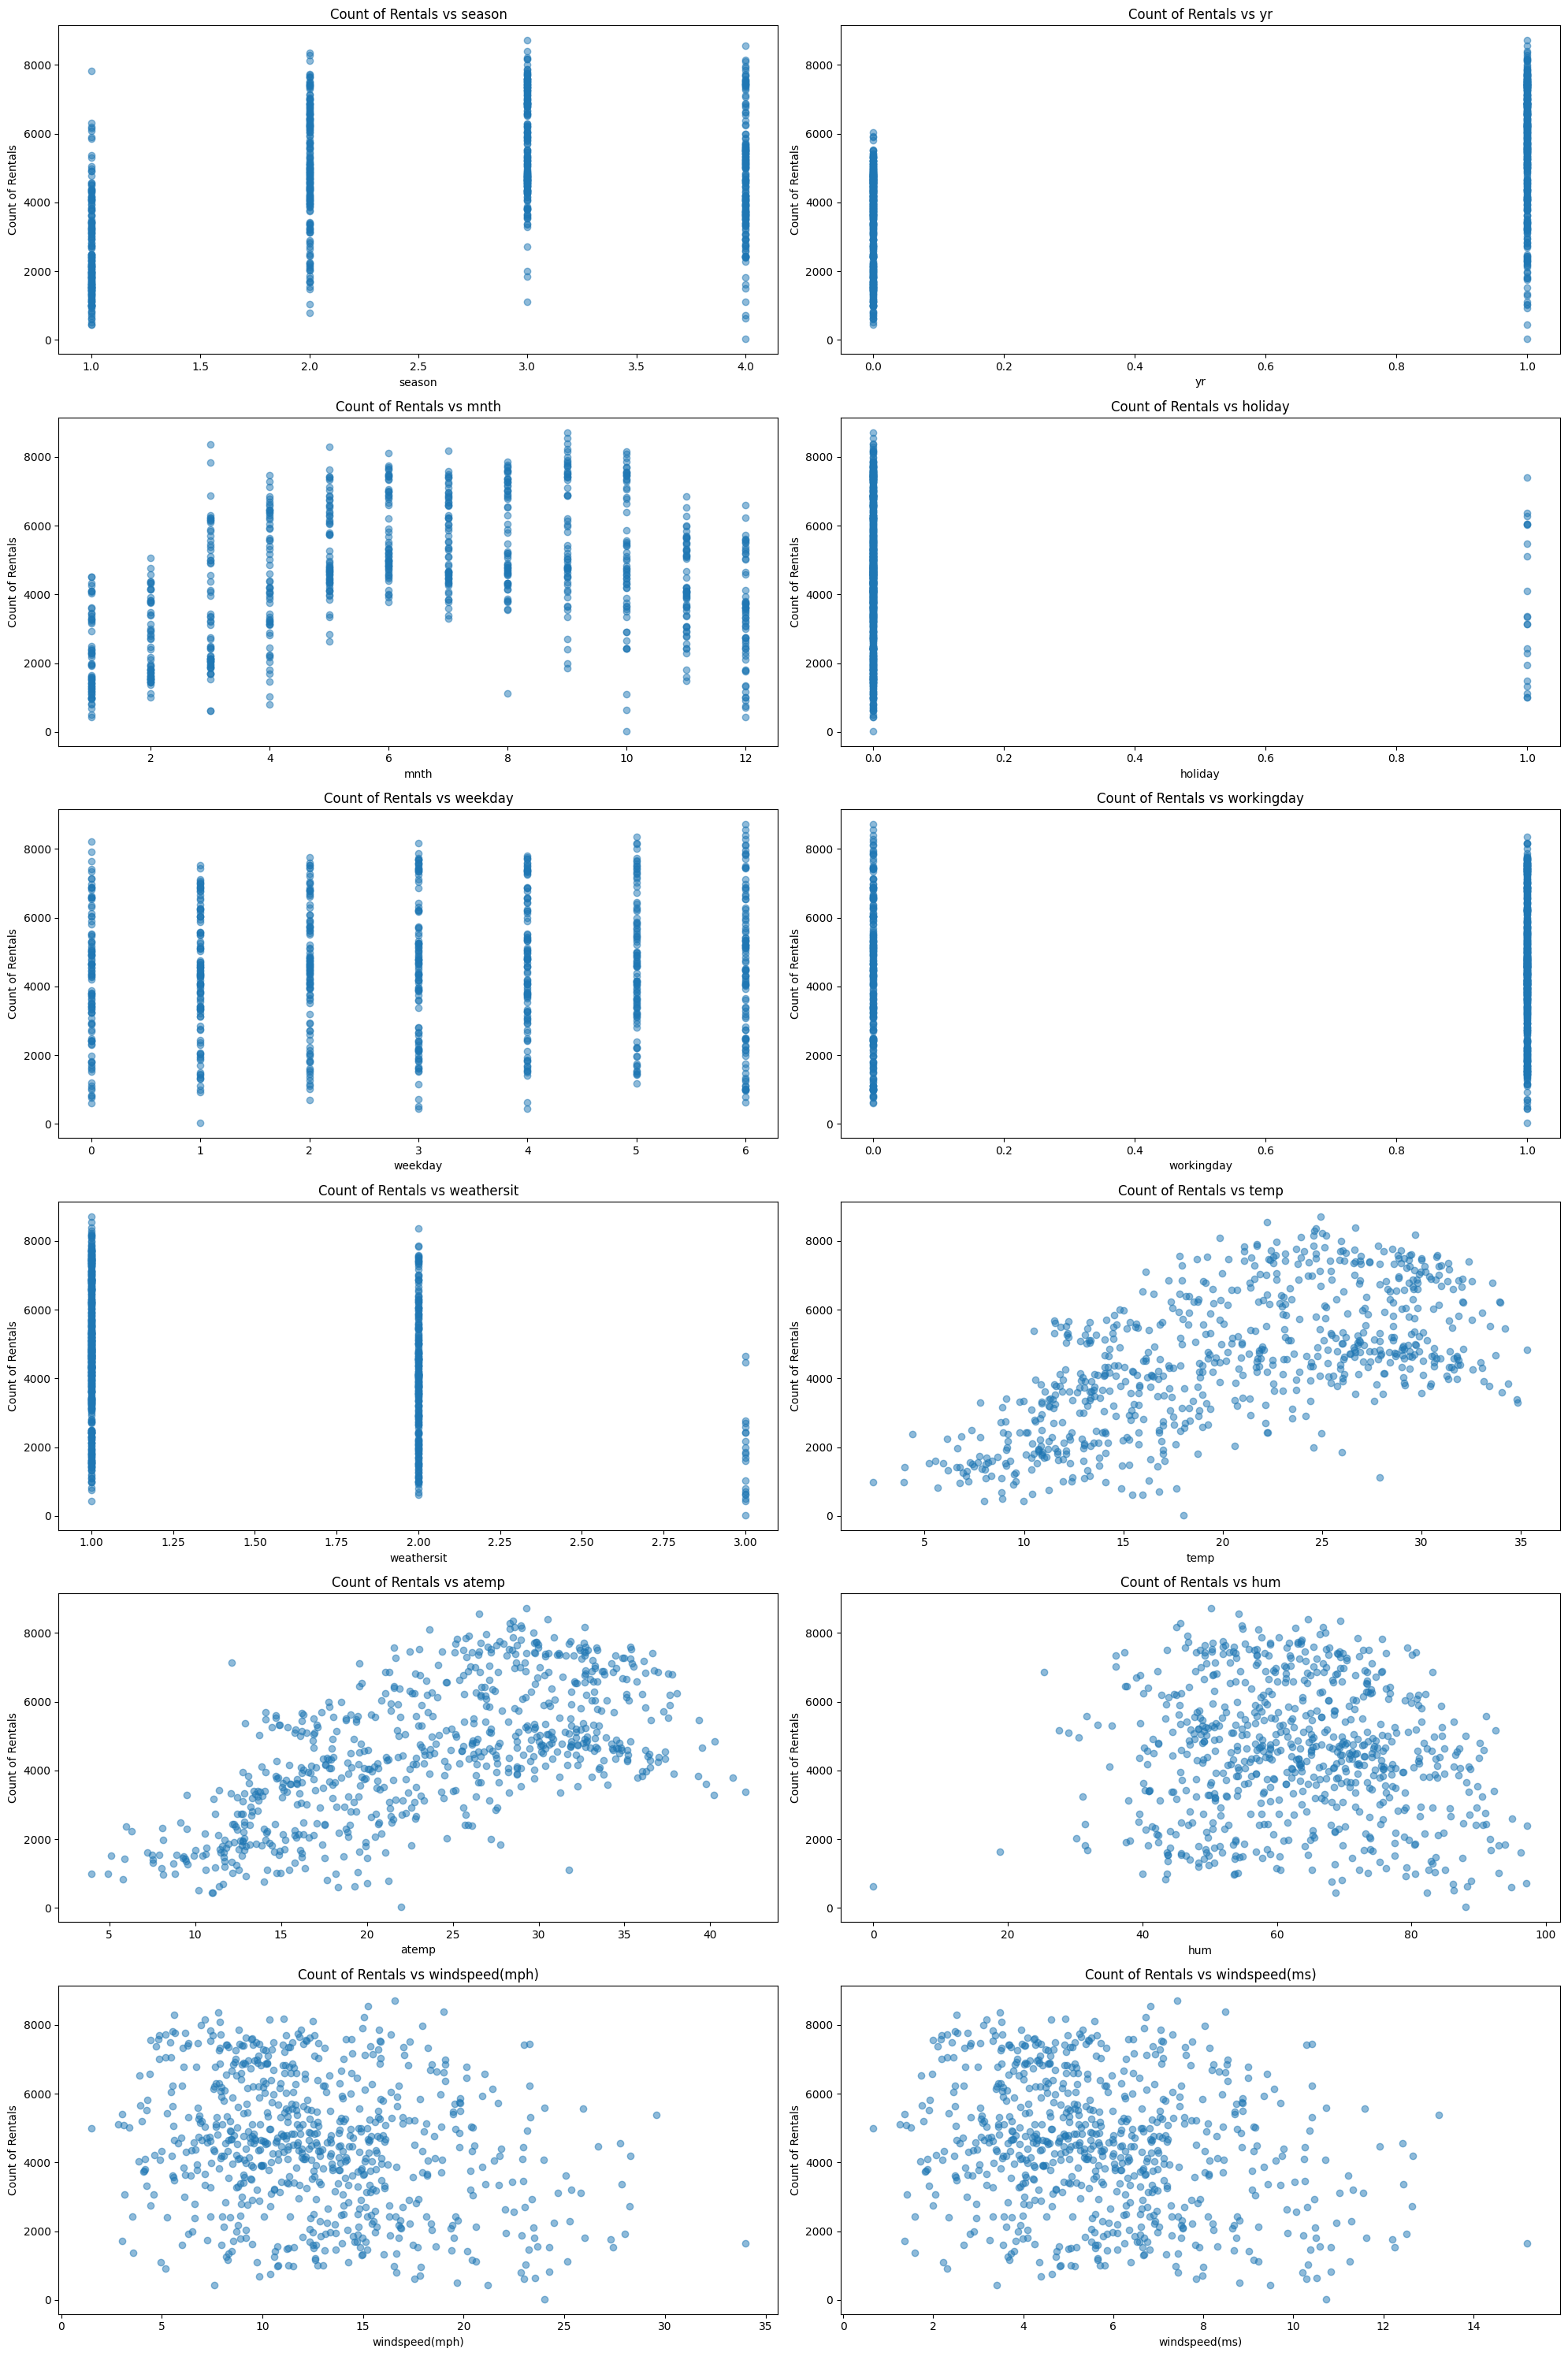

In [3]:
# List of feature names
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Building graphs
plt.figure(figsize=(20, 30))
for i, feature in enumerate(features, start=1):
    plt.subplot(6, 2, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Count of Rentals')
    plt.title(f'Count of Rentals vs {feature}')
plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

A graph of the number of rentals versus month shows that the relationship is shaped like a curve, with the number of rentals varying seasonally. Typically, there are more rentals in spring and summer and fewer in winter. This indicates a non-linear dependence on the month.

The attributes that are most likely to have a linear relationship with the number of hires are temp (temperature in Celsius) and atemp (temperature by sensation in Celsius). It is logical to assume that as the temperature increases, more people decide to rent bicycles, and this relationship may be approximately linear.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [4]:
# Calculate correlations between all features (except the last one) and the last feature 'cnt'
correlations = df.iloc[:, :-1].corrwith(df['cnt'])

# Displaying correlations for each feature
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [5]:
# Вибираємо потрібні ознаки
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення попарних кореляцій
pairwise_correlations = df[selected_features].corr()

# Виведення результатів
print(pairwise_correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [6]:
print(df.mean())

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [9]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [10]:
regressor = LinearRegression()

# Training the regressor on all data except the last column (target feature 'cnt')
X = df.drop(columns=['cnt'])
y = df['cnt']
regressor.fit(X, y)

# Displaying model weights
print("Model weights:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Model weights:
season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [11]:
from sklearn.linear_model import Lasso

# Creating a linear regressor object with L1 regularisation (Lasso)
lasso_regressor = Lasso()

# Training the regressor on all data except the last column (target feature 'cnt')
lasso_regressor.fit(X, y)

# Output of the Lasso model scales
print("Lasso model scales:")
for feature, coef in zip(df.columns[:-1], lasso_regressor.coef_):
    print(f"{feature}: {coef}")

Lasso model scales:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [12]:
from sklearn.linear_model import Ridge

# Creating a linear regressor object with L2 regularisation (Ridge)
ridge_regressor = Ridge()

# Training the regressor on all data except the last column (target feature 'cnt')
ridge_regressor.fit(X, y)

# Output of the Ridge model scales
print("Ridge model scales:")
for feature, coef in zip(df.columns[:-1], ridge_regressor.coef_):
    print(f"{feature}: {coef}")

Ridge model scales:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [13]:
# The value of the regularisation coefficient alpha
alphas = np.arange(1, 500, 50)

# Empty lists for saving weights of Lasso and Ridge models
coefs_lasso = []
coefs_ridge = []

# Training regressors for each value of alpha
for alpha in alphas:
    # Training a Lasso regressor
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    # Training the Ridge regressor
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

# Converting lists to NumPy arrays
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

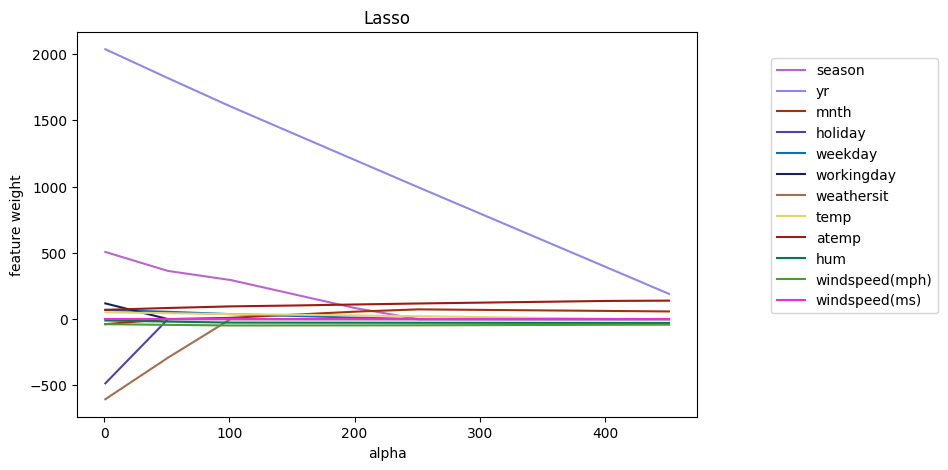

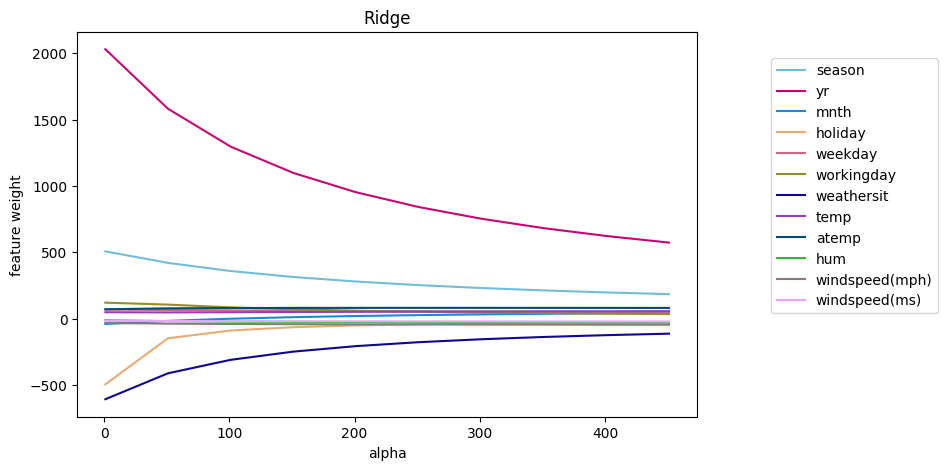

In [14]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. The Lasso regulator reduces weights more aggressively for the same alpha value compared to the Ridge regulator. This can be seen in the graphs, where the weights for Lasso decrease to zero faster with increasing alpha values.

2. If you make alpha very large in the Lasso method, all weights will be reduced to zero except for the constant term (which corresponds to the mean value of the target feature). This is because a large value of alpha leads to strong regularisation, which requires limiting the sum of the absolute values of the coefficients as much as possible.

3. For example, Lasso excludes one of the windspeed features at any value of alpha > 0, as the coefficient for this feature decreases to zero. In the case of Ridge, since it uses a quadratic penalty function, the coefficient will not decrease to zero, but it will be very small.

4. Lasso is more suitable for selecting uninformative features because it is able to aggressively reduce the weights to zero, which leads to the exclusion of these features from the model. Ridge can also help in reducing the weights of uninformative features, but is less effective as the weights are reduced but not to zero.

a) Регуляризатор Lasso агресивніше зменшує ваги при одному й тому самому значенні alpha порівняно з регуляризатором Ridge. Це можна спостерігати на графіках, де ваги для Lasso швидше зменшуються до нуля зі збільшенням значень alpha.

b) Якщо зробити alpha дуже великим у методі Lasso, то всі ваги будуть зменшені до нуля, крім константного члена (який відповідає середньому значенню цільової ознаки). Це відбувається через те, що велике значення alpha призводить до сильної регуляризації, що вимагає максимального обмеження суми абсолютних значень коефіцієнтів.

c) Так, Lasso виключає одну з ознак windspeed при будь-якому значенні alpha > 0, оскільки коефіцієнт при цій ознаці зменшується до нуля. У випадку з Ridge, оскільки він використовує квадратичну штрафну функцію, коефіцієнт не зменшиться до нуля, але буде дуже малим.

d) Lasso більш підходить для відбору неінформативних ознак, оскільки він здатний агресивно зменшувати ваги до нуля, що призводить до виключення цих ознак з моделі. Ridge також може допомогти у зменшенні ваг неінформативних ознак, але менш ефективно, оскільки ваги зменшуються, але не до нуля.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [15]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

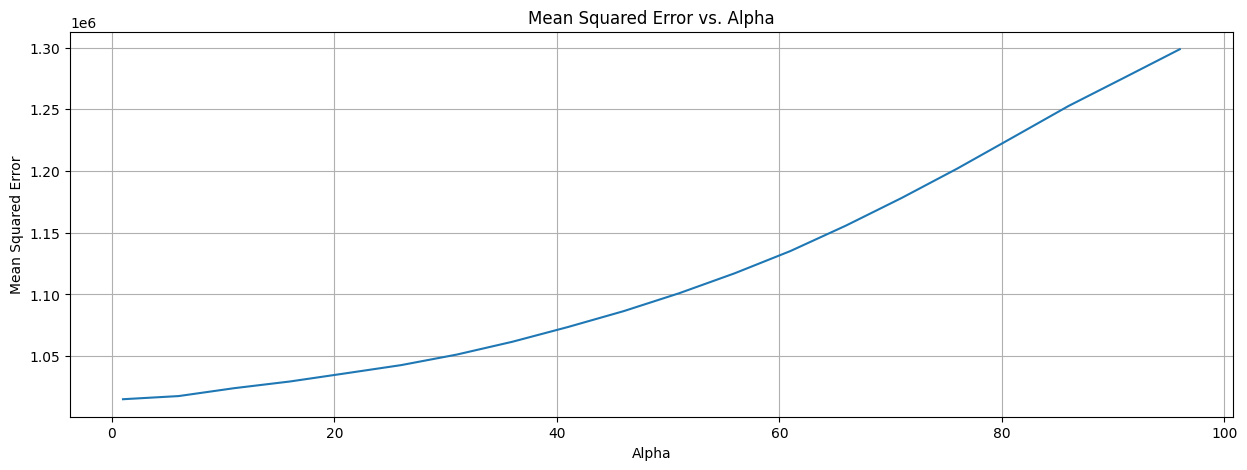

Вибране alpha: 1
Feature-coefficient pairs:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


In [16]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = [e[0] for e in data]
    y = [e[1] for e in data]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

alphas = np.arange(1, 100, 5)

# Creating a LassoCV object with a list of alpha values
regressor = LassoCV(alphas=alphas)

# Training the regressor on all data except the last column (target feature 'cnt')
regressor.fit(X, y)

# The average MSE value for each alpha
mse_means = np.mean(regressor.mse_path_, axis=1)

# Graphing the row-averaged MSE as a function of alpha
create_plot(list(zip(regressor.alphas_, mse_means)),
            title="Mean Squared Error vs. Alpha",
            xlabel="Alpha",
            ylabel="Mean Squared Error")

# Outputting the selected alpha
print("Вибране alpha:", regressor.alpha_)

# Output of feature-coefficient pairs for the trained coefficient vector
print("Feature-coefficient pairs:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


The alpha values corresponding to the MSE minimums at each partition:
Розбиття 1: 51
Розбиття 2: 1
Розбиття 3: 96
Розбиття 4: 1
Розбиття 5: 1


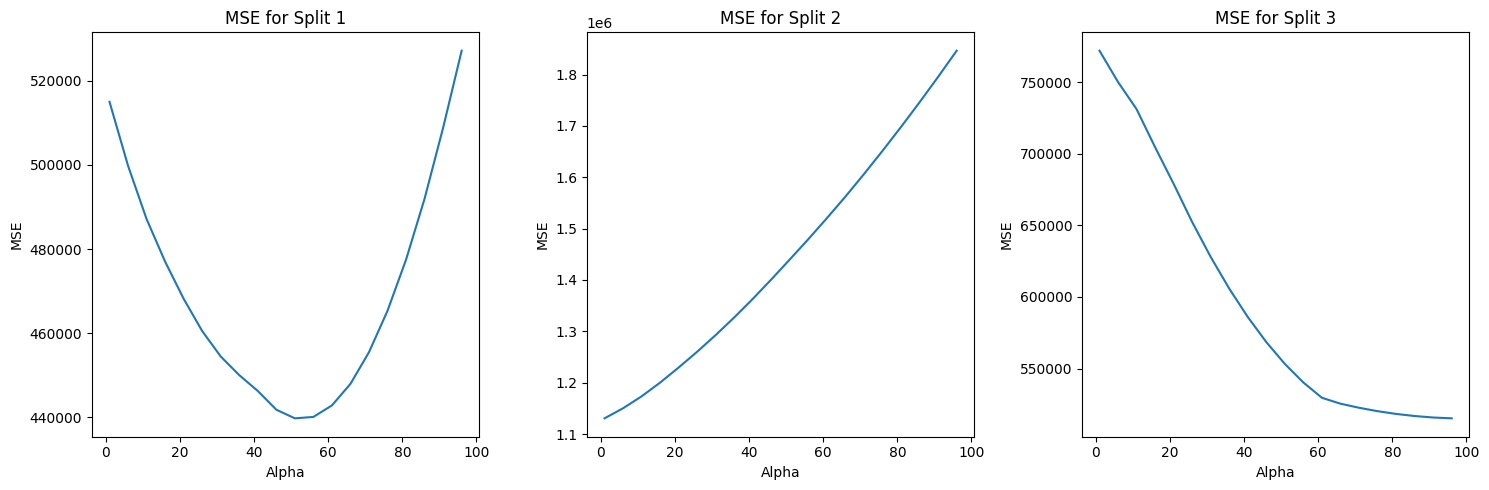

In [19]:
# Print the alpha values corresponding to the minimum MSE on each partition
min_mse_indices = np.argmin(regressor.mse_path_, axis=0)
print("The alpha values corresponding to the MSE minimums at each partition:")
for i, index in enumerate(min_mse_indices):
    print(f"Розбиття {i+1}: {regressor.alphas_[index]}")

# Visualisation of mse_path_ columns
plt.figure(figsize=(15, 5))

num_plots = min(3, regressor.mse_path_.shape[1])  # Limit the number of sub-graphs to three
for i in range(num_plots):
    plt.subplot(1, num_plots, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i])
    plt.title(f"MSE for Split {i+1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")

plt.tight_layout()
plt.show()

Alphas with minimum MSE:
Alpha = 41, MSE = 843336.181499
Alpha = 6, MSE = 772598.495628
Alpha = 1, MSE = 745668.605961

Each partition has its own optimal alpha value, and it corresponds to a large MSE on other partitions. It turns out that we are adjusting to specific training and control samples. When selecting alpha for cross-validation, we choose a somewhat "average" value that will give an acceptable metric value on different sample splits.

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

4 features with the highest positive coefficients:
yr: 2036.2316676979037
weathersit: -604.5667118927049
season: 506.5512786498074
holiday: -484.65194618654056


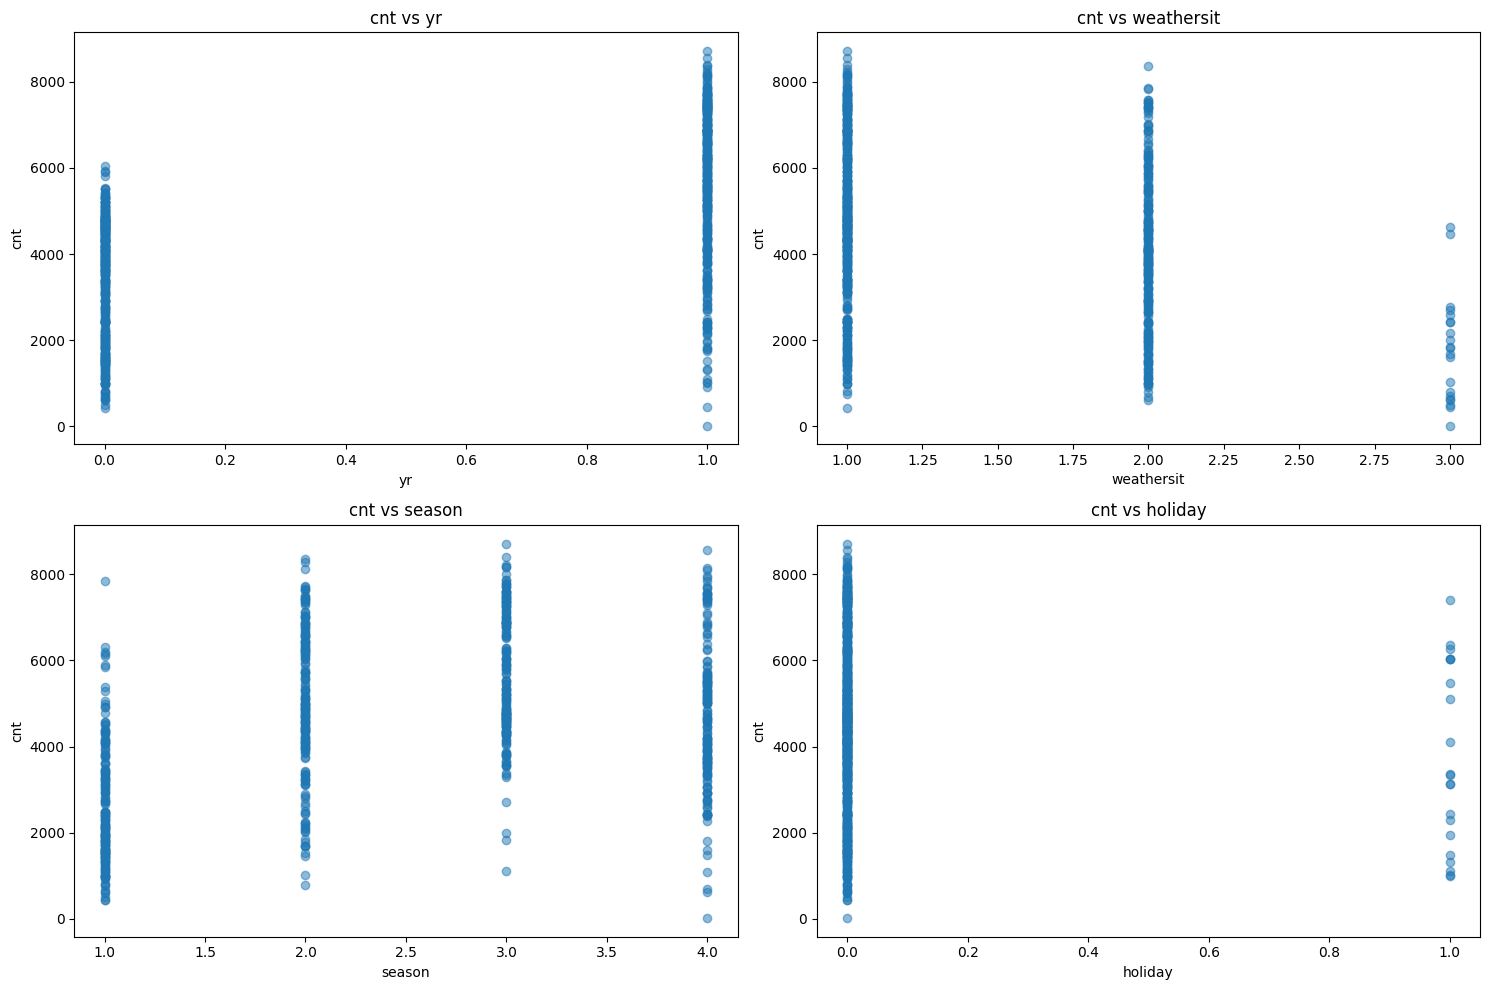

In [21]:
# Selection of features with the highest positive coefficients
top_features = sorted(zip(df.columns, regressor.coef_), key=lambda x: -abs(x[1]))[:4]
top_positive_features = [feat for feat, coef in top_features]

print("4 features with the highest positive coefficients:")
for feat, coef in top_features:
    print(f"{feat}: {coef}")

# Drawing graphs of cnt dependence on selected features
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_positive_features):
    plt.subplot(2, 2, i+1)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'cnt vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

This code identifies the 4 attributes with the highest positive coefficients and plots the graphs of the dependence of the number of rentals on these attributes.

After executing this code, we can analyse the graphs and draw conclusions about the increasing linear dependence of cnt on these attributes and the logic of such statements.

If the graphs show a positive correlation between the traits and cnt, this will confirm the increasing linear dependence. It is logical to assert that the higher the value of these attributes, the more people will want to take up bicycles if these attributes truly reflect factors that influence bicycle demand, such as temperature, humidity, holidays, etc.


Цей код визначає 4 ознаки з найбільшими позитивними коефіцієнтами та побудовує графіки залежності кількості прокатів від цих ознак.

Після виконання цього коду ми можемо проаналізувати графіки та зробити висновки про зростаючу лінійну залежність cnt від цих ознак і логічність таких стверджень.

Якщо на графіках буде помітна позитивна кореляція між ознаками та cnt, це буде підтвердженням зростаючої лінійної залежності. Логічно стверджувати, що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди, якщо ці ознаки дійсно відображають фактори, які впливають на попит на велосипеди, наприклад, температура, вологість, свята тощо.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

3 attributes with the largest negative coefficients by module:
windspeed(ms): -0.0
hum: -10.352705204636573
mnth: -38.07827028932167


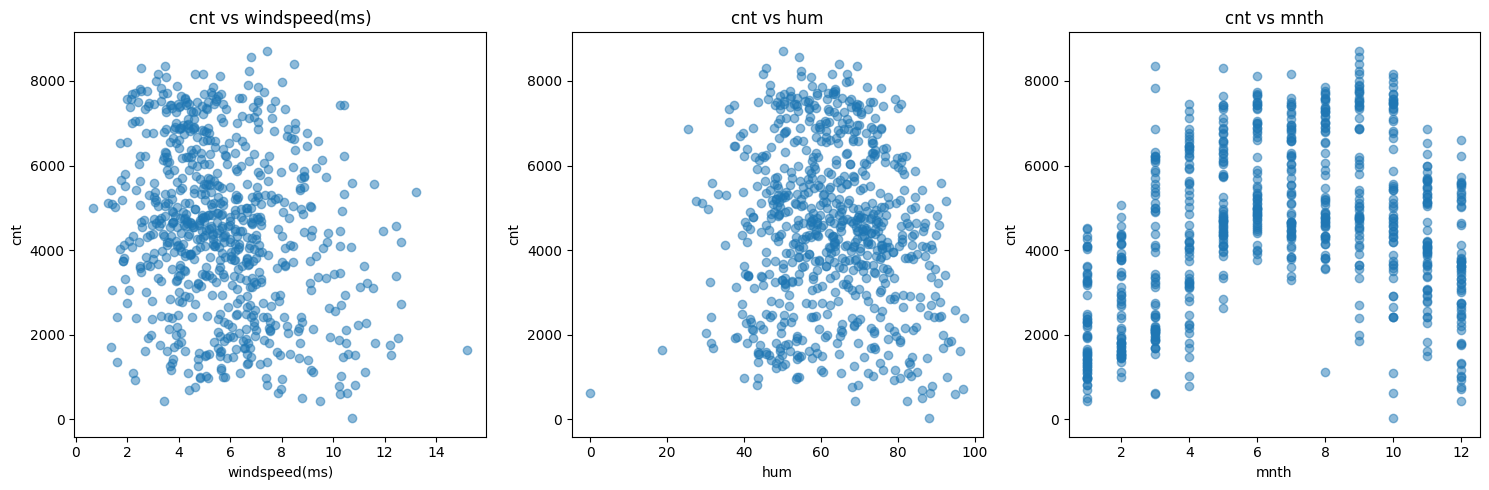

In [22]:
# Selection of features with the largest modulo negative coefficients
top_negative_features = sorted(zip(df.columns, regressor.coef_), key=lambda x: abs(x[1]))[:3]

print("3 attributes with the largest negative coefficients by module:")
for feat, coef in top_negative_features:
    print(f"{feat}: {coef}")

# Drawing graphs of cnt dependence on selected features
plt.figure(figsize=(15, 5))

for i, feature in enumerate(top_negative_features):
    plt.subplot(1, 3, i+1)
    plt.scatter(df[feature[0]], df['cnt'], alpha=0.5)
    plt.title(f'cnt vs {feature[0]}')
    plt.xlabel(feature[0])
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

This code identifies the 3 features with the largest negative coefficients by module and plots the graphs of the dependence of the number of rentals on these features.

After executing this code, we can analyse the graphs and draw conclusions about the decreasing linear dependence and the logic of such statements. If the graphs show a negative correlation between the attributes and cnt, this will confirm the decreasing linear relationship. It is logical to argue that the higher the magnitude of these attributes, the fewer people will want to take bicycles if these attributes do indeed reflect factors that influence bicycle demand, such as rain, strong winds, etc.

Цей код визначає 3 ознаки з найбільшими за модулем негативними коефіцієнтами та побудовує графіки залежності кількості прокатів від цих ознак.

Після виконання цього коду ми можемо проаналізувати графіки та зробити висновки щодо зменшуючоїся лінійної залежності та логічності таких стверджень. Якщо на графіках буде помітна негативна кореляція між ознаками та cnt, це буде підтвердженням зменшуючоїся лінійної залежності. Логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди, якщо ці ознаки дійсно відображають фактори, які впливають на попит на велосипеди, наприклад, дощ, сильний вітер тощо.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Signs with coefficients close to zero (< 1e-3):
windspeed(ms): -0.0


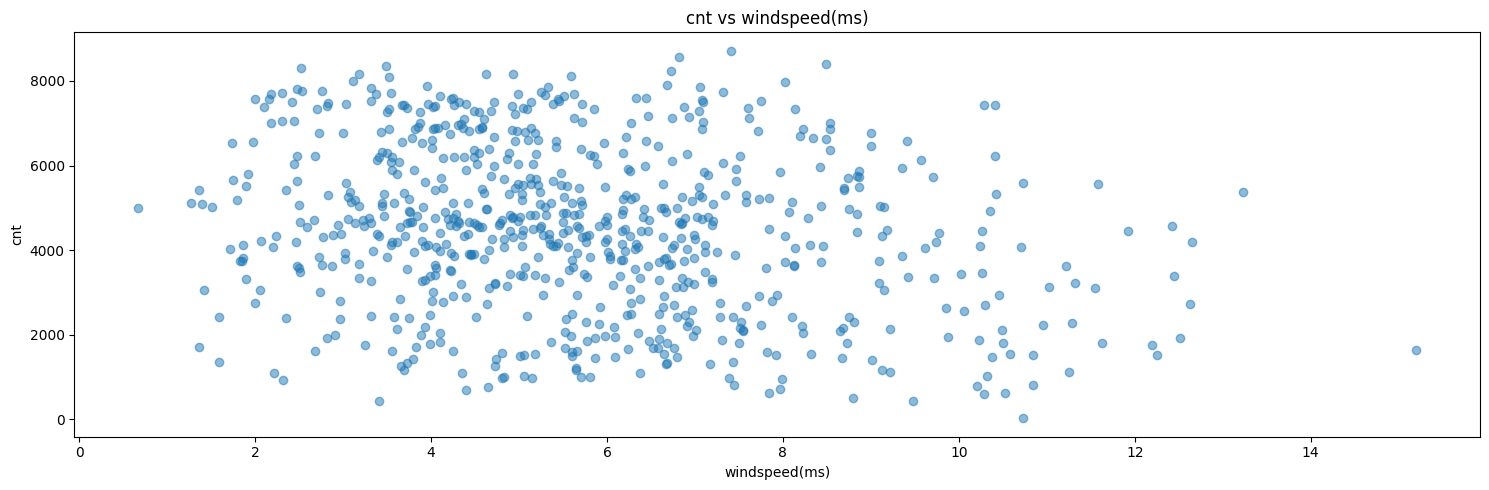

In [23]:
# Selection of features with coefficients close to zero
near_zero_features = [(feat, coef) for feat, coef in zip(df.columns, regressor.coef_) if abs(coef) < 1e-3]

print("Signs with coefficients close to zero (< 1e-3):")
for feat, coef in near_zero_features:
    print(f"{feat}: {coef}")

# Drawing graphs of cnt dependence on features with coefficients close to zero
plt.figure(figsize=(15, 5))

for i, feature in enumerate(near_zero_features):
    plt.subplot(1, len(near_zero_features), i+1)
    plt.scatter(df[feature[0]], df['cnt'], alpha=0.5)
    plt.title(f'cnt vs {feature[0]}')
    plt.xlabel(feature[0])
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

This code outputs the attributes with coefficients close to zero and plots the number of rentals against these attributes.

After running this code, we can analyse the graphs and draw conclusions about whether these attributes can be assumed to have no effect on the demand for bicycles. If the graphs show that a change in these variables affects the number of rentals, then the model can exclude them because they are interrelated with other variables or because they have insufficient correlation with the target variable.

Цей код виводить ознаки з коефіцієнтами, близькими до нуля, та побудовує графіки залежності кількості прокатів від цих ознак.

Після виконання цього коду ми можемо проаналізувати графіки та зробити висновки щодо того, чи можна вважати, що ці ознаки ніяк не впливають на попит на велосипеди. Якщо на графіках буде помітно, що зміна цих ознак впливає на кількість прокатів, то модель може виключати їх через їхню взаємозв'язаність з іншими ознаками або через недостатню кореляцію з цільовою змінною.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.